#Импрот библиотек

In [199]:
import pandas as pd
import re
import numpy as np
import ast
import sys
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
import category_encoders as ce
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

#Чтение данных

In [200]:
DATA_DIR = '/kaggle/input/sf-booking/'
TARGET_NAME = 'reviewer_score'
RANDOM_STATE = 42

In [201]:
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv')
df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')

Удаляем дубли из тренировочных данных

In [202]:
df_train_ = df_train.drop_duplicates()
print(df_train.shape[0])
print(df_train_.shape[0])

386803
386496


In [203]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test[TARGET_NAME] = 0
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)
hotels.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


#Работа с данными

Считаем числовое значение количества дней

In [204]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda value: np.int64(re.search('\d+', value).group(0)))

**Работаем с тегами**

Отвечаем на вопрос сколько тегов

In [205]:
tags = set();

def parse_tags(value, tags):
  cur_tags = set(map(str.strip, ast.literal_eval(value)))
  tags.update(cur_tags)

hotels['tags'].apply(lambda value: parse_tags(value, tags))

print(f"Количество тэгов: {len(tags)}")

Количество тэгов: 2428


Похоже, что тэги разбиты на 5 категорий: тип поездки, количество путешествий, тип номера, количество ночей, и как отправлено сообщение. Попробуем собрать отдельно по категориям и проанализировать их.

In [206]:
cp_hotels = hotels.copy()
def parse_tags_values(value, index):
  index_shift= 0
  cur_tags = list(map(str.strip, ast.literal_eval(value)))
  # В некоторых строках нет первого тега, смещаем индекс на 1 вправо
  if(cur_tags[0] not in ['Leisure trip', 'Business trip']):
    if index == 0:
      return '---'
    index = index - 1
    #index_shift = index_shift + 1


  #if cur_tags[1 - cu]
  return cur_tags[index] if len(cur_tags) > index else '---'

#print(parse_tags_values("[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"))
cp_hotels['trip_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 0))
cp_hotels['trip_travelers_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 1))
cp_hotels['trip_room_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 2))
cp_hotels['trip_days_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 3))
cp_hotels['from_mobile'] = cp_hotels['tags'].apply(lambda value: parse_tags_values(value, 4))



In [207]:
cp_hotels['trip_type'].value_counts()

Leisure trip     416672
Business trip     82748
---               16318
Name: trip_type, dtype: int64

In [208]:
cp_hotels['trip_travelers_count'].value_counts()

Couple                        251554
Solo traveler                 108336
Group                          65251
Family with young children     60791
Family with older children     26258
Travelers with friends          2143
With a pet                      1405
Name: trip_travelers_count, dtype: int64

In [209]:
cp_hotels['trip_room_type'].value_counts().head(100)

Double Room                35124
Standard Double Room       32175
Superior Double Room       31304
Deluxe Double Room         24765
Double or Twin Room        22311
                           ...  
King Hilton Guest Room       644
Double Room 1 Adult          622
Art King Room                610
Deluxe Room Barlow Wing      605
Standard King Room           599
Name: trip_room_type, Length: 100, dtype: int64

In [210]:
cp_hotels['trip_days_count'].value_counts().head(50)

Stayed 1 night                  193052
Stayed 2 nights                 133568
Stayed 3 nights                  95577
Stayed 4 nights                  47722
Stayed 5 nights                  20796
Stayed 6 nights                   9759
Stayed 7 nights                   7380
Stayed 8 nights                   2498
Stayed 9 nights                   1290
Stayed 10 nights                   886
Couple                             698
Stayed 11 nights                   416
Stayed 12 nights                   315
Stayed 13 nights                   246
Stayed 14 nights                   245
Family with young children         206
---                                190
Solo traveler                      177
Group                              129
Stayed 15 nights                   117
Family with older children          87
Stayed 16 nights                    57
Stayed 17 nights                    42
Stayed 18 nights                    32
Stayed 19 nights                    29
Stayed 21 nights         

In [211]:
cp_hotels['from_mobile'].value_counts().head(50)

Submitted from a mobile device         306712
---                                    207623
Superior Double Room                       84
Double Room                                78
Double or Twin Room                        74
Standard Double Room                       69
Classic Double Room                        56
2 rooms                                    51
Deluxe Double Room                         51
Stayed 1 night                             41
Superior Double or Twin Room               37
Standard Double or Twin Room               35
Classic Room                               29
Stayed 2 nights                            27
Double or Twin Room 1 2 Adults             23
Deluxe Double or Twin Room                 20
Classic Double or Twin Room                19
Twin Room                                  19
Deluxe Room                                19
Stayed 3 nights                            18
Standard Twin Room                         16
Standard Room                     

**вывод по тэгам** - т.к. тэги не всегда расположены в одинаковом порядке мы потеряем часть данных если попытаемся парсить тэги опираясь на их порядок. Поэтому выделим группы для 1, 2, 4 и 5 тэгов, а остальные скинем в 3.

In [212]:

def parse_tags(value):
  return list(map(str.strip, ast.literal_eval(value)))

def parse_tags_trip_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_trip_type(tag):
      return tag

  return '---'

def parse_tags_travelers_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_travelers_type(tag):
      return tag

  return '---'

def parse_tags_trip_days_count(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_days_count(tag):
      return tag

  return '---'

def parse_tags_from_mobile(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if is_from_mobile(tag):
      return 1

  return 0

def parse_tags_room_type(value):
  cur_tags = parse_tags(value)
  for tag in cur_tags:
    if not is_days_count(tag) and not is_trip_type(tag) and not is_travelers_type(tag) and not is_from_mobile(tag):
      return tag

  return '---'

def is_trip_type(tag):
  if(tag in ['Leisure trip', 'Business trip']):
    return True
  
  return False

def is_travelers_type(tag):
  if(tag in ['Couple', 'Solo traveler', 'Family with young children', 'Group',
       'Family with older children', 'Travelers with friends',
       'With a pet']):
    return True
  return False

def is_days_count(tag):
  return 'Stayed ' in tag

def is_from_mobile(tag):
  return tag == 'Submitted from a mobile device'

#print(parse_tags_values("[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"))
hotels['trip_type'] = hotels['tags'].apply(lambda value: parse_tags_trip_type(value))
hotels['trip_travelers_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_travelers_type(value))
hotels['trip_room_type'] = cp_hotels['tags'].apply(lambda value: parse_tags_room_type(value))
hotels['trip_days_count'] = cp_hotels['tags'].apply(lambda value: parse_tags_trip_days_count(value))
hotels['from_mobile'] = cp_hotels['tags'].apply(lambda value: parse_tags_from_mobile(value))

In [213]:
hotels['trip_type'].value_counts()

Leisure trip     417778
Business trip     82939
---               15021
Name: trip_type, dtype: int64

In [214]:
hotels['trip_travelers_type'].value_counts()

Couple                        251554
Solo traveler                 108336
Group                          65251
Family with young children     60791
Family with older children     26258
Travelers with friends          2143
With a pet                      1405
Name: trip_travelers_type, dtype: int64

In [215]:
hotels['trip_days_count'].value_counts().head(50)

Stayed 1 night      193645
Stayed 2 nights     133937
Stayed 3 nights      95821
Stayed 4 nights      47817
Stayed 5 nights      20845
Stayed 6 nights       9776
Stayed 7 nights       7399
Stayed 8 nights       2502
Stayed 9 nights       1293
Stayed 10 nights       889
Stayed 11 nights       418
Stayed 12 nights       316
Stayed 14 nights       247
Stayed 13 nights       246
---                    192
Stayed 15 nights       117
Stayed 16 nights        57
Stayed 17 nights        42
Stayed 18 nights        33
Stayed 19 nights        29
Stayed 21 nights        23
Stayed 20 nights        19
Stayed 27 nights        11
Stayed 30 nights        11
Stayed 23 nights        10
Stayed 22 nights        10
Stayed 25 nights         7
Stayed 26 nights         7
Stayed 28 nights         7
Stayed 24 nights         6
Stayed 29 nights         5
Stayed 31 nights         1
Name: trip_days_count, dtype: int64

In [216]:
hotels['trip_room_type'].value_counts().head(100)

Double Room                35207
Standard Double Room       32248
Superior Double Room       31393
Deluxe Double Room         24823
Double or Twin Room        22393
                           ...  
Double Room 1 Adult          623
Art King Room                610
Deluxe Room Barlow Wing      607
Standard King Room           599
Premium Double Room          594
Name: trip_room_type, Length: 100, dtype: int64

In [217]:
hotels['from_mobile'].value_counts()

1    307640
0    208098
Name: from_mobile, dtype: int64

Теперь данные из тэгов гораздо валиднее, с ними можно работать дальше

**Поработаем с данными**

Из колонок с длительностью путешествия достанем количество

In [218]:

def parse_days(value):
  val = re.search('\d+', value)
  if val == None:
    return val

  return np.int64(val.group(0))
hotels['trip_days_count'] = hotels['trip_days_count'].apply(parse_days)

Используем OneHotEncoder для trip_type, trip_travelers_type

In [219]:
enc = ce.OneHotEncoder(cols=['trip_type', 'trip_travelers_type'])

enc_data  = enc.fit_transform(hotels[['trip_type', 'trip_travelers_type']])
hotels_1 = pd.concat([hotels, enc_data], axis=1)

**Заполняем пропуски**

In [220]:
tmp = hotels_1.isnull().sum()
tmp

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
trip_type                                        0
trip_travelers_type            

In [221]:
hotels_3 = hotels_1.fillna({
    'lat': hotels_1['lat'].median(),
    'lng': hotels_1['lng'].median(),
    'trip_days_count': hotels_1['trip_days_count'].median()
})

In [222]:
tmp = hotels_3.isnull().sum()
tmp

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
trip_type                                     0
trip_travelers_type                           0
trip_room_type                          

Преобразуем колонку trip_room_type с помощью BinaryEncoder

In [223]:
enc = ce.BinaryEncoder(cols=['trip_room_type', 'hotel_name'])

enc_data  = enc.fit_transform(hotels[['trip_room_type', 'hotel_name']])
hotels_4 = pd.concat([hotels_3, enc_data], axis=1)

In [224]:
hotels_4.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,0,0,1,0


In [225]:
hotels_4['review_date'] = pd.to_datetime(hotels_4['review_date'])

Создадим колонку с количеством прошедших дней со дня отзыва

In [226]:
hotels_4['days_last'] = (datetime.now() - hotels_4['review_date']).dt.days
hotels_4['month'] = hotels_4['review_date'].dt.month.astype(int)
hotels_4['day'] = hotels_4['review_date'].dt.day.astype(int)
hotels_4['day_of_week'] = hotels_4['review_date'].dt.dayofweek.astype(int)

In [227]:
hotels_4['city'] = hotels_4['hotel_address'].apply(
    lambda value: 'London' if value.endswith('United Kingdom') else value.split()[-2]
)
population = {
    'Paris'    : 2148327,
    'London'   : 8908081,
    'Milan'    : 1366180, 
    'Vienna'   : 1911191,
    'Barcelona': 1636732,
    'Amsterdam': 860124
}
hotels_4['population'] = hotels_4['city'].map(population)

In [228]:
hotels_4.head(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,days_last,month,day,day_of_week,city,population
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,1,1713,7,21,4,Milan,1366180
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,1,0,1934,12,12,0,Amsterdam,860124
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0,1,1,2316,11,26,3,Barcelona,1636732
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,1,0,0,2356,10,17,5,Milan,1366180
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,1,0,1,2144,5,16,0,Amsterdam,860124
5,Coram Street Camden London WC1N 1HT United Kin...,709,2015-08-13,8.2,Holiday Inn London Bloomsbury,Ecuador,They don t have free wifi,7,2995,The location is perfect if you don t have a l...,...,0,1,1,0,2421,8,13,3,London,8908081
6,Empire Way Wembley Brent London HA9 8DS United...,1005,2016-08-18,8.3,Holiday Inn London Wembley,United Kingdom,Room generally a bit shabby with some lack of...,35,3469,Location price It did not cost much more to h...,...,0,1,1,1,2050,8,18,3,London,8908081
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,2015-08-11,8.3,Novotel London West,Netherlands,Executive rooms 9th Floor don t have a bath T...,52,2443,Comphy bed upgraded to executive room with ne...,...,1,0,0,0,2423,8,11,1,London,8908081
8,35 Rue Caumartin 9th arr 75009 Paris France,211,2016-06-25,8.9,Hotel Saint Petersbourg Opera,Ireland,Pity about the two days of rain,8,2412,Its centrality proximity to our destination,...,1,0,0,1,2104,6,25,5,Paris,2148327
9,49 Gloucester Place Marble Arch Westminster Bo...,61,2015-09-30,7.4,St George Hotel,Canada,Didn t like it at all construction was in pro...,18,334,Didn t like anything about the stay if i had ...,...,1,0,1,0,2373,9,30,2,London,8908081


In [229]:
hotels_5 = hotels_4.drop(['review_date', 'city'], axis=1)

In [230]:
hotels_5['is_positive_review'] = hotels_5['positive_review'].apply(
    lambda value: 0 if value.lower().strip() in ['nothing', 'none', 'n a', 'no positive'] else 1  
) 
hotels_5['is_negative_review'] = hotels_5['negative_review'].apply(
    lambda value: 0 if value.lower().strip() in ['nothing', 'none', 'n a', 'no negative'] else 1
)
hotels_5['review_total_negative_word_counts'] = hotels_5.apply(
    lambda row: 0 if row['is_negative_review'] == 0 else row['review_total_negative_word_counts'],
    axis=1
)
hotels_5['review_total_positive_word_counts'] = hotels_5.apply(
    lambda row: 0 if row['is_positive_review'] == 0 else row['review_total_positive_word_counts'],
    axis=1
)

In [231]:
enc = ce.BinaryEncoder(cols=['reviewer_nationality'])

enc_data  = enc.fit_transform(hotels[['reviewer_nationality']])
hotels_5 = pd.concat([hotels_5, enc_data], axis=1)

#Отбор признаков

**Оценим мультиколериальность**

<AxesSubplot:>

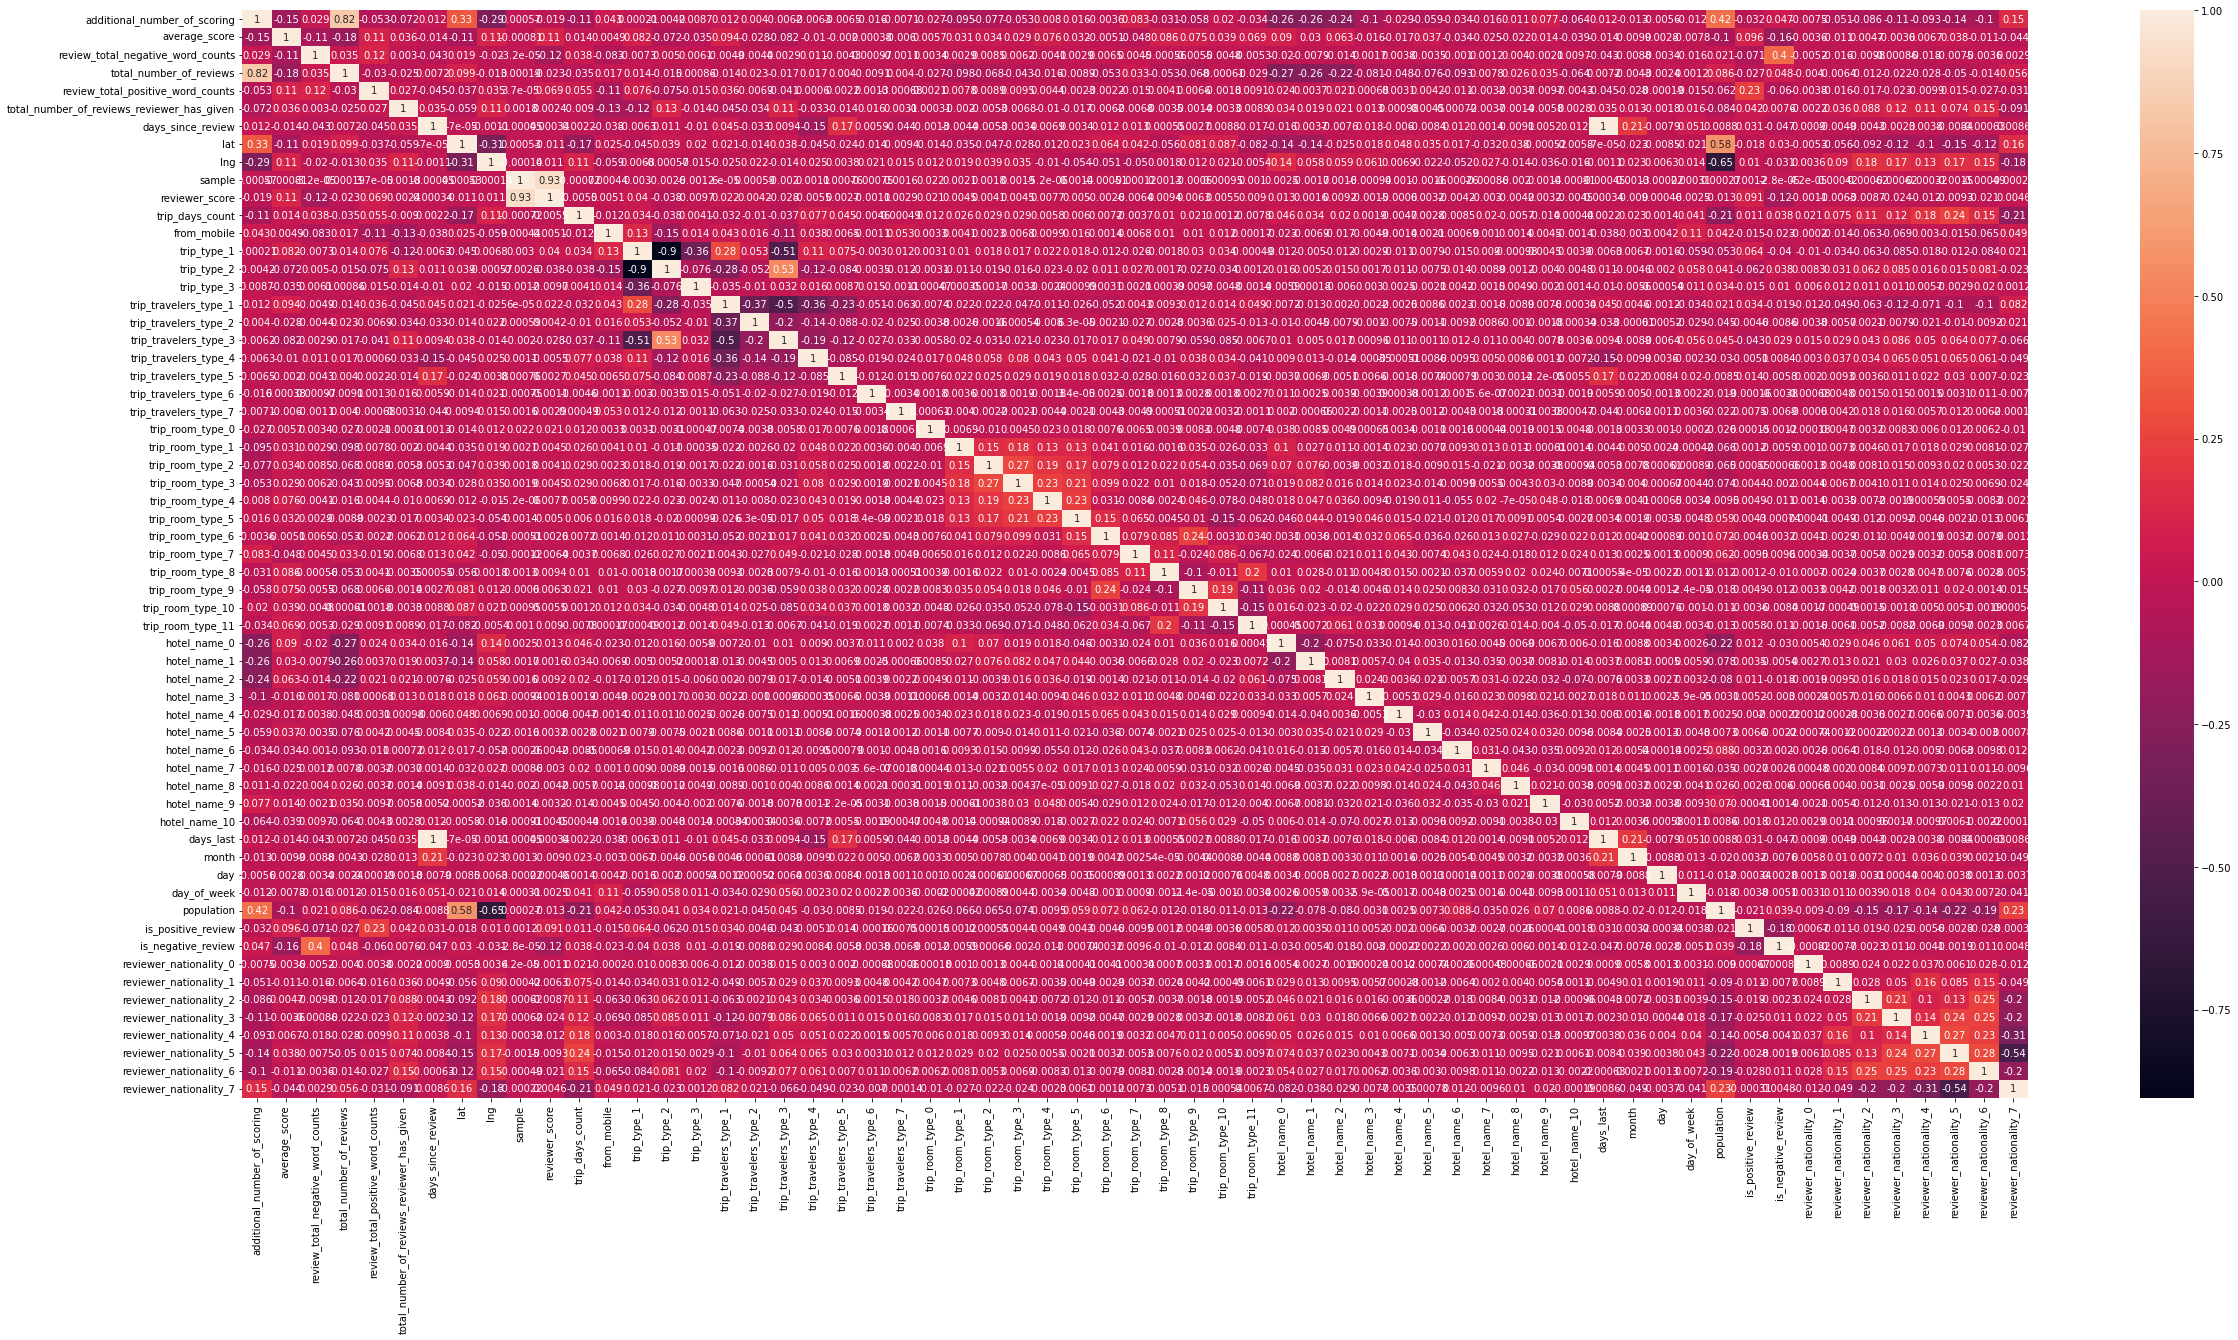

In [232]:
plt.figure(figsize=(40, 20))
sns.heatmap(hotels_5.corr(), annot=True)

Можно удалить колонки: total_number_of_reviews, days_since_review, trip_type_2

In [233]:
hotels_6 = hotels_5.drop(['total_number_of_reviews', 'days_since_review', 'trip_type_2', 'lat', 'lng'], axis=1)

<AxesSubplot:>

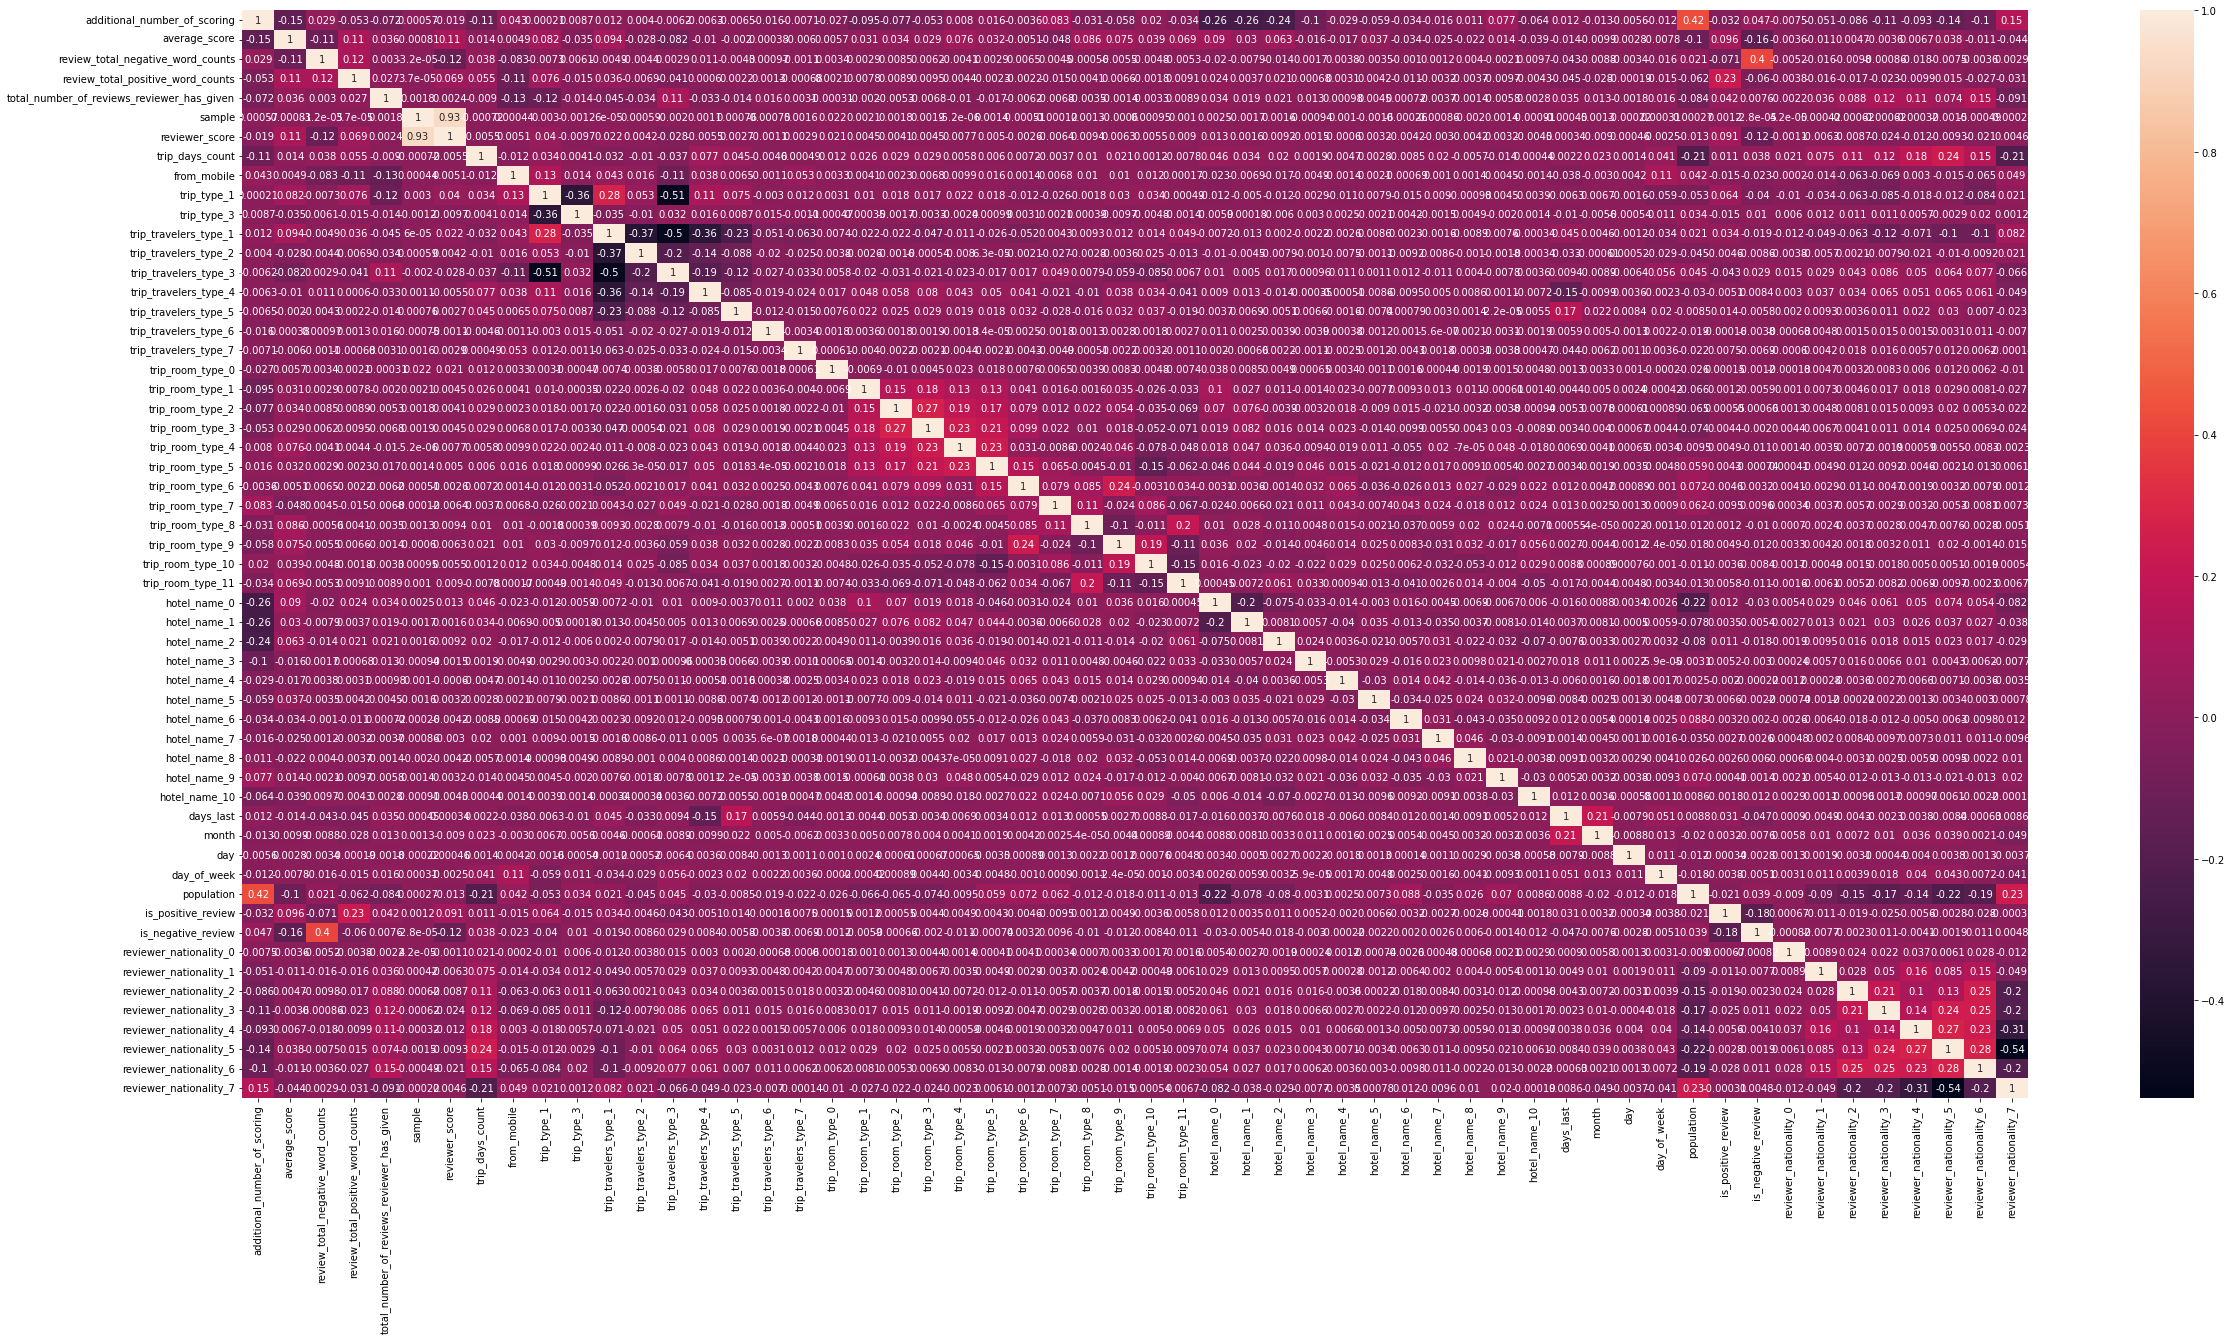

In [234]:
plt.figure(figsize=(40, 20))
sns.heatmap(hotels_6.corr(), annot=True)

In [235]:
hotels_final = hotels_6.copy()

Удаляем текстовые колонки

In [236]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels_final.columns if hotels_final[s].dtypes == 'object']
hotels_final.drop(object_columns, axis = 1, inplace=True)


In [237]:
train_data = hotels_final[hotels_final['sample'] == 1].copy()
test_data = hotels_final[hotels_final['sample'] == 0].copy()

train_data.drop(['sample'],axis=1,inplace=True)
test_data.drop(['sample',TARGET_NAME],axis=1,inplace=True)

In [244]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop([TARGET_NAME], axis = 1)  
y = train_data[TARGET_NAME] 

**Оценим влияние колонок на результат**

In [245]:
# непрерывные признаки
num_cols = ['total_number_of_reviews_reviewer_has_given', 
            'review_total_negative_word_counts',
            'additional_number_of_scoring',
            'days_last'
            ]

# категориальные признаки
cat_cols = ['average_score', 'reviewer_nationality_1','reviewer_nationality_2','reviewer_nationality_3', 'reviewer_nationality_4', 'is_positive_review', 'is_negative_review']

<AxesSubplot:>

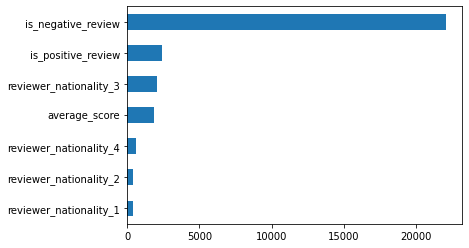

In [246]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

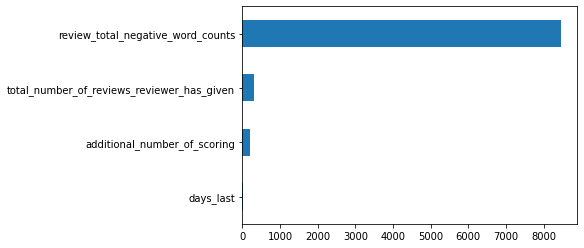

In [247]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [248]:
#удалим свойства 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring',
X = X.drop(['days_last'], axis=1)
test_data = test_data.drop(['days_last'], axis=1)
#Удаление приводит к ухудшению результата

In [249]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [250]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_STATE)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


In [251]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.15874906915450226


In [252]:
#Расчитываем тестовые данные
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [253]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_3.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.30,488440
1,6.91,274649
2,7.63,374688
3,9.63,404352
4,9.44,451596
5,8.32,302161
6,7.79,317079
7,7.71,13963
8,8.09,159785
9,7.72,195089
